In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
# import gradio as gr

##### Load data into tf.Dataset

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 10  #works better at 15-98% accuracy

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"plantvillage",
shuffle=True,                    #Shuffling the dataset randomly reorders the data for each iteration
image_size = (IMAGE_SIZE,IMAGE_SIZE), #size of the image 
batch_size = BATCH_SIZE               #No of images in one batch
)

Found 5702 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) 

179

In [6]:
179*32    
#179*32 = 5728 , *Last batch is not perfect so it show some extra value 
# total 179 dataset with 32 images each since we have only 5702 images the last 

5728

#### To view the data (data visualizion)

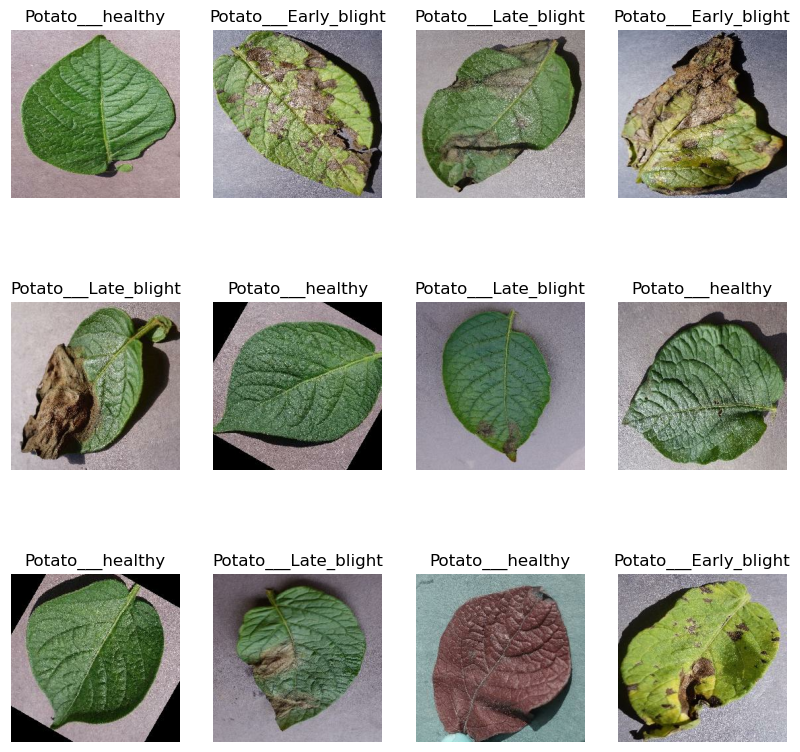

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1): #take 1 batch(from 179) with 32 images
#     print(image_batch.shape) #32 images with 256*256 size, 3-RGB CHANNELS
#     print(label_batch.numpy())#0,1,2 -> 3 classes
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # to convert float to int
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

179

## TRAIN_TEST_SPLIT

In [9]:
train_size=0.8
len(dataset)*train_size #80% of dataset

143.20000000000002

In [10]:
train_ds=dataset.take(143)  #calling this 143 out of 179 into train_ds 
len(train_ds)

143

In [11]:
test_ds=dataset.skip(143)  #rest is passed to the test_ds
len(test_ds)

36

In [12]:
val_size=0.1                #validation dataset is 17
len(dataset)*val_size

17.900000000000002

In [13]:
val_ds=test_ds.take(17)     #copied to validation dataset
len(val_ds)

17

In [14]:
test_ds=test_ds.skip(17)    #rest is passed to test_ds
len(test_ds)

19

In [15]:
def get_datset_partitions_tf(ds, train_split=0.8, val_split=0.1,
                             test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds,test_ds

In [16]:
train_ds, val_ds,test_ds = get_datset_partitions_tf(dataset)

In [17]:
len(train_ds)

143

In [18]:
len(val_ds)

17

In [19]:
len(test_ds)

19

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#read the image the disk when it is again loaded it will be stored in the memory


optimization for performance


In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds
)

Epoch 1/10
143/143 [==============================] - 190s 1s/step - loss: 0.7438 - accuracy: 0.6545 - val_loss: 0.5484 - val_accuracy: 0.7739
Epoch 2/10
143/143 [==============================] - 178s 1s/step - loss: 0.3652 - accuracy: 0.8545 - val_loss: 0.2331 - val_accuracy: 0.9099
Epoch 3/10
143/143 [==============================] - 183s 1s/step - loss: 0.2514 - accuracy: 0.9037 - val_loss: 0.3662 - val_accuracy: 0.8566
Epoch 4/10
143/143 [==============================] - 204s 1s/step - loss: 0.1574 - accuracy: 0.9424 - val_loss: 0.1398 - val_accuracy: 0.9577
Epoch 5/10
143/143 [==============================] - 214s 2s/step - loss: 0.0923 - accuracy: 0.9646 - val_loss: 0.4656 - val_accuracy: 0.8805
Epoch 6/10
143/143 [==============================] - 207s 1s/step - loss: 0.1217 - accuracy: 0.9580 - val_loss: 0.0872 - val_accuracy: 0.9669
Epoch 7/10
143/143 [==============================] - 210s 1s/step - loss: 0.0708 - accuracy: 0.9727 - val_loss: 0.1024 - val_accuracy: 0.9614

In [27]:
scores = model.evaluate(test_ds)


19/19 [==============================] - 13s 441ms/step - loss: 0.1204 - accuracy: 0.9655


In [28]:
scores

[0.12038159370422363, 0.9654605388641357]

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 143}

In [31]:
acc=history.history['accuracy']
#print(acc)
vali_acc=history.history['val_accuracy']
#print(vali_acc)
loss=history.history['loss']
vali_loss=history.history['val_loss']

### plot training and validation accuracy 

In [32]:
# plt.figure(figsize=(8,8))
# plt.subplot(1,2,1)
# plt.plot(range(EPOCHS), acc, label='Training accuracy')
# pt.plot(range(EPOCHS), vali_acc, label='Validation accuracy')
# pt.legend(loc='lower right')
# pt.title('Training and Validation Accuracy')

# pt.subplot(1,2,2)
# pt.plot(range(EPOCHS), loss, label='Training loss')
# pt.plot(range(EPOCHS), vali_loss, label='Validation loss')
# pt.legend(loc='upper right')
# pt.title('Training and Validation loss')

Text(0.5, 1.0, 'Training and validation loss')

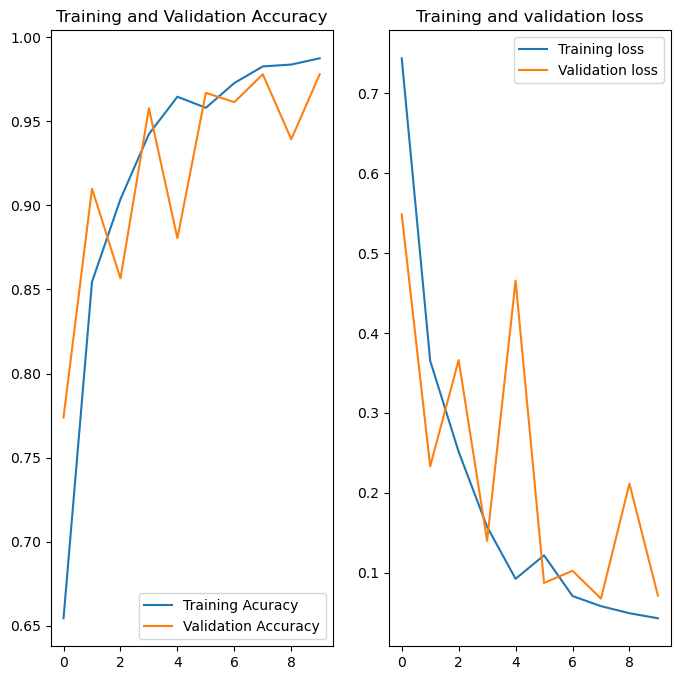

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Acuracy')
plt.plot(range(EPOCHS), vali_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS),vali_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

In [34]:
import numpy as np

first image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 1s 652ms/step
predicted label: Potato___Early_blight


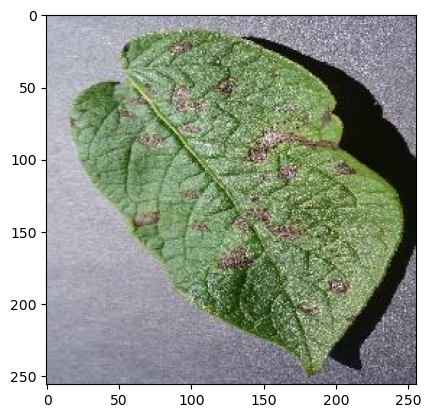

In [35]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch [0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    
    print("actual label: ",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [36]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) 
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions=model.predict(img_array)

    predicted_class= class_names[np.argmax(predictions[0])] 
    confidence = round(100*(np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


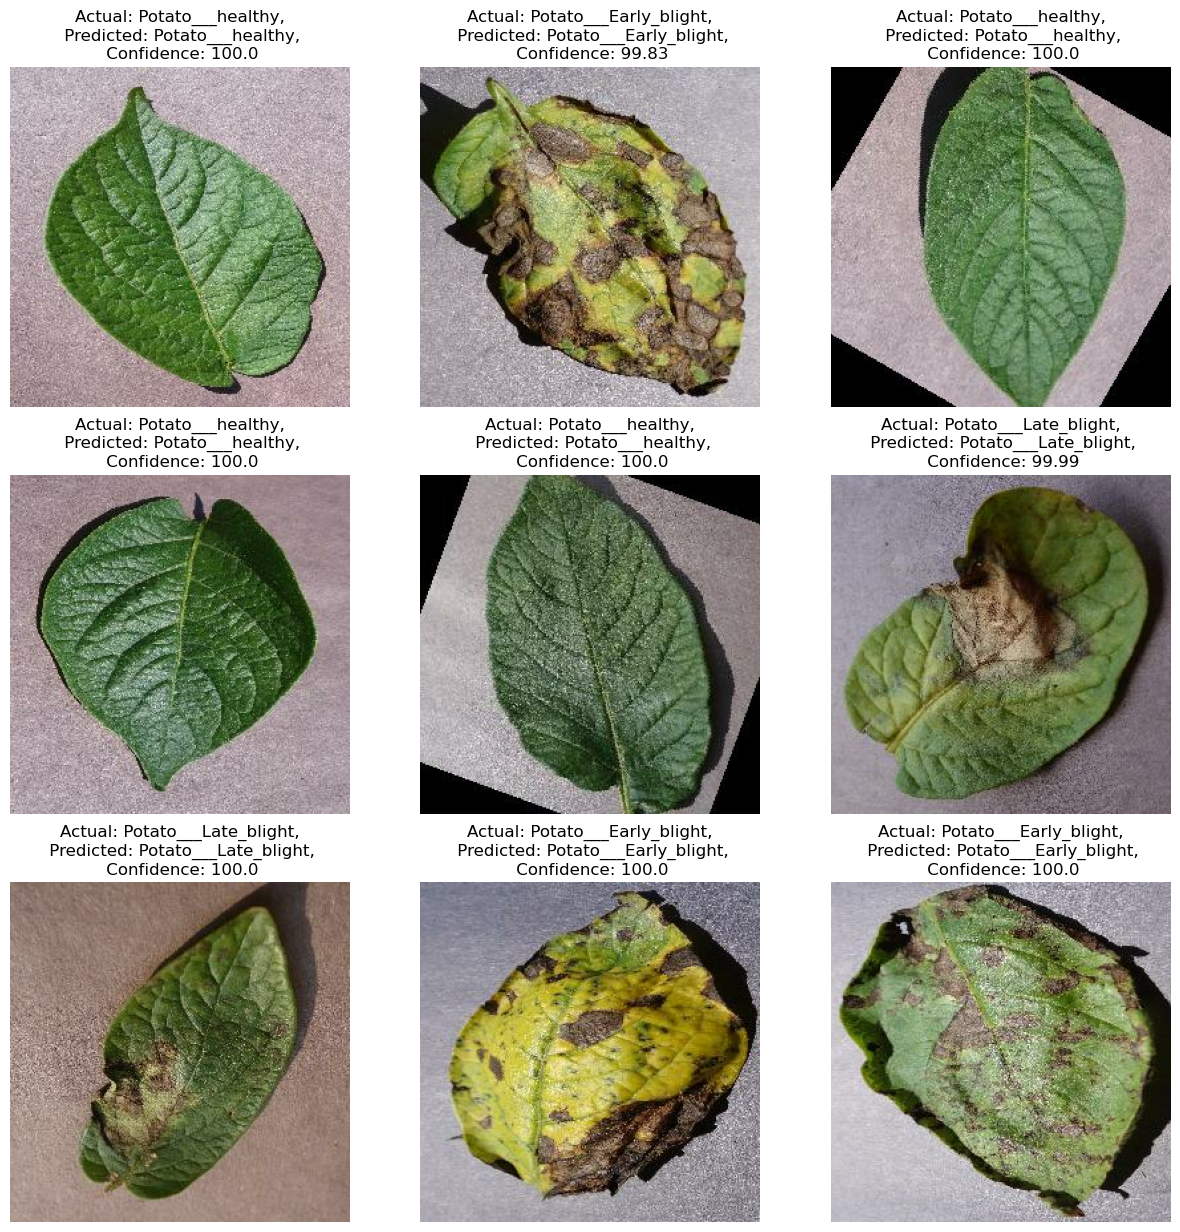

In [37]:
plt.figure(figsize=(15, 15)) 
for images, labels in test_ds.take(1):

    for i in range(9) :

        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")

        plt.axis("off")

In [38]:
# model_version=1
# model.save(f"../models/{model_version}")
# ## we can do some alteration in the CNN model and create more model 

In [39]:
#To view different model in the file 

In [40]:
import gradio as gr


In [41]:
def predict_image(img):
  img_4d=img.reshape(-1,180,180,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}

In [ ]:
image = gr.inputs.Image(shape=(180,180))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8584\2926149329.py:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(180,180))
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8584\2926149329.py:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(180,180))
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8584\2926149329.py:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=3)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8584\2926149329.py:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=3)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


# 